Iteration 1, Delta: 69.5240300198269
Iteration 2, Delta: 61.165052440119624
Iteration 3, Delta: 52.39272906433291
Iteration 4, Delta: 44.38849028183043
Iteration 5, Delta: 37.52958356831763
Iteration 6, Delta: 31.979957914645013
Iteration 7, Delta: 27.548677687101133
Iteration 8, Delta: 23.98725847594085
Iteration 9, Delta: 21.077958363826042
Iteration 10, Delta: 18.63884514977127
Iteration 11, Delta: 16.557107439376125
Iteration 12, Delta: 14.754599039852963
Iteration 13, Delta: 13.176764034426071
Iteration 14, Delta: 11.784756192470468
Iteration 15, Delta: 10.550003886897855
Iteration 16, Delta: 9.450685031218597
Iteration 17, Delta: 8.469507150951245
Iteration 18, Delta: 7.592319146845114
Iteration 19, Delta: 6.807235329778678
Iteration 20, Delta: 6.104072807240186
Iteration 21, Delta: 5.473980609597106
Iteration 22, Delta: 4.909186760615455
Iteration 23, Delta: 4.402818728293596
Iteration 24, Delta: 3.948770381455631
Iteration 25, Delta: 3.5415992012070774
Iteration 26, Delta: 3.17

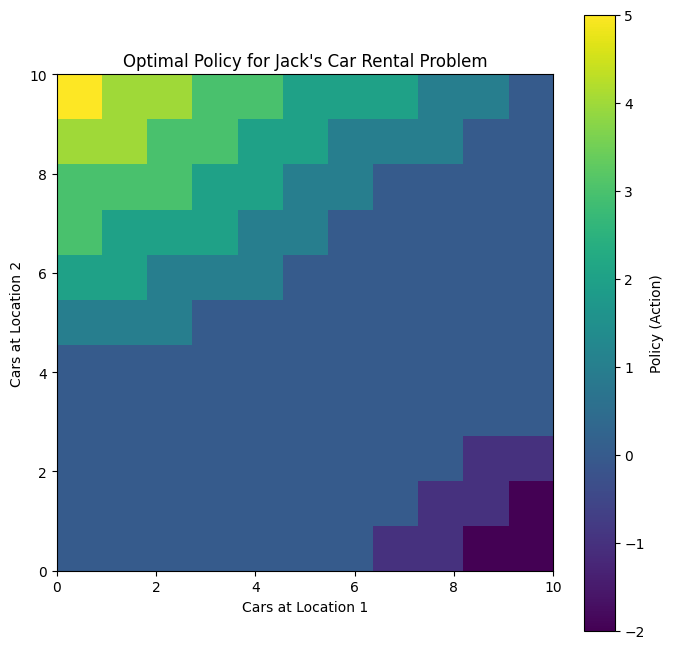

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from numba import jit

# Parameters
MAX_CARS = 10  
MAX_MOVE = 5  # Maximum cars that can be moved overnight
RENTAL_CREDIT = 10  # Reward for each car rented
MOVE_COST = 2  # Cost of moving each car
DISCOUNT = 0.9  # Discount factor for future rewards
THRESHOLD = 1e-4  # Convergence threshold

# Poisson distribution parameters
RENTAL_REQUESTS_LOC1 = 3
RENTAL_REQUESTS_LOC2 = 4
RETURNS_LOC1 = 3
RETURNS_LOC2 = 2

# Precompute Poisson probabilities for efficiency
def precompute_poisson_probs(max_cars, lambdas):
    probs = np.zeros((len(lambdas), max_cars + 2))
    for idx, lam in enumerate(lambdas):
        for n in range(max_cars + 1):
            probs[idx, n] = poisson.pmf(n, lam)
        probs[idx, -1] = 1 - probs[idx, :-1].sum()  # Tail probability
    return probs

poisson_probs = precompute_poisson_probs(MAX_CARS, [RENTAL_REQUESTS_LOC1, RENTAL_REQUESTS_LOC2, RETURNS_LOC1, RETURNS_LOC2])

# State-value function and policy
value_function = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

@jit(nopython=True)
def expected_return(state, action, value_function, max_cars, discount, move_cost, rental_credit, rental_probs, return_probs):
    """
    Compute the expected return for a given state and action.
    """
    returns = 0.0
    cars_loc1 = state[0] - action
    cars_loc2 = state[1] + action

    for rentals1 in range(max_cars + 1):
        for rentals2 in range(max_cars + 1):
            prob_rentals = rental_probs[0, rentals1] * rental_probs[1, rentals2]
            rented_cars1 = min(cars_loc1, rentals1)
            rented_cars2 = min(cars_loc2, rentals2)
            reward = (rented_cars1 + rented_cars2) * rental_credit

            remaining_cars1 = cars_loc1 - rented_cars1
            remaining_cars2 = cars_loc2 - rented_cars2

            for returns1 in range(max_cars + 1):
                for returns2 in range(max_cars + 1):
                    prob_returns = return_probs[0, returns1] * return_probs[1, returns2]
                    cars1 = min(remaining_cars1 + returns1, max_cars)
                    cars2 = min(remaining_cars2 + returns2, max_cars)

                    prob = prob_rentals * prob_returns
                    returns += prob * (reward - move_cost * abs(action) + discount * value_function[cars1, cars2])

    return returns

def value_iteration():
    global value_function, policy
    iteration = 0

    while True:
        delta = 0
        new_value_function = np.zeros_like(value_function)

        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                state = (i, j)
                action_values = []

                for action in range(-MAX_MOVE, MAX_MOVE + 1):
                    if 0 <= state[0] - action <= MAX_CARS and 0 <= state[1] + action <= MAX_CARS:
                        action_values.append(
                            expected_return(state, action, value_function, MAX_CARS, DISCOUNT, MOVE_COST, RENTAL_CREDIT,
                                            poisson_probs[:2], poisson_probs[2:])
                        )
                    else:
                        action_values.append(-np.inf)

                new_value_function[i, j] = max(action_values)
                delta = max(delta, abs(new_value_function[i, j] - value_function[i, j]))

        value_function[:] = new_value_function
        iteration += 1
        print(f"Iteration {iteration}, Delta: {delta}")

        if delta < THRESHOLD:
            break

    # Update the policy
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            state = (i, j)
            action_values = []
            for action in range(-MAX_MOVE, MAX_MOVE + 1):
                if 0 <= state[0] - action <= MAX_CARS and 0 <= state[1] + action <= MAX_CARS:
                    action_values.append(
                        expected_return(state, action, value_function, MAX_CARS, DISCOUNT, MOVE_COST, RENTAL_CREDIT,
                                        poisson_probs[:2], poisson_probs[2:])
                    )
                else:
                    action_values.append(-np.inf)

            policy[i, j] = range(-MAX_MOVE, MAX_MOVE + 1)[np.argmax(action_values)]

# Run Value Iteration
value_iteration()

# Plot the optimal policy
plt.figure(figsize=(8, 8))
plt.imshow(policy, origin='lower', cmap='viridis', extent=[0, MAX_CARS, 0, MAX_CARS])
plt.colorbar(label='Policy (Action)')
plt.xlabel('Cars at Location 1')
plt.ylabel('Cars at Location 2')
plt.title('Optimal Policy for Jack\'s Car Rental Problem')
plt.grid(False)
plt.show()


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
